## ORTC Computation
The ORTC problem is a linear programming (LP) problem and always has solutions since the cost function is linear together with a nonempty closed, bounded, convex polyhedral feasible set.

This notebook introduces code for solving ORTC problems and explains the functions that are computationally efficient for finding solutions. Additionally, it aims to explore the significance of ORTC solutions by applying them to various graph examples.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import numpy as np
import networkx as nx
from random import randint
import random

import time
from scipy.stats import entropy
import matplotlib.pyplot as plt

from ortc.utils import *
from ortc.glop_v2 import glop_v2
from ortc.ortc_v2 import ortc_v2
from ortc.ortc_v1 import ortc_v1
from otc.exactOTC import exact_otc
from ortc.entropicORTC import entropic_ortc
from ortc.entropicORTC_log import entropic_ortc_log
from experiment.isomorphism import *

### Vertex-based vs. Edge-based implementation
The ORTC problem is formulated as a LP problem, but its scale grows significantly as the graph size increases. For instance, when comparing two graphs with 100 vertices each, the LP problem involves 100 million variables.

However, upon closely examining the transition coupling condition, we observe that $w((u,v),(u',v'))$ can be positive only if $u$ is connected to $u'$ and $v$ is connected to $v'$. This means that (for sparse graphs) most elements of $w$ will be zero. Inspired by this, we developed an implementation that reduces the problem’s scale by considering only the non-zero variables, i.e., only weights that can be positive. We call this the edge-based implementation, while the original method, which uses all variables, is referred to as the vertex-based implementation.

Next, we will examine how the problem’s scale reduces with the edge-based implementation compared to the vertex-based approach, by analyzing the number of variables and constraints.
Let $n_1$ and $e_1$ represent the number of vertices and edges in graph $G_1$, and let $n_2$ and $e_2$ denote the number of vertices and edges in graph $G_2$. We now present the number of variables and constraints required for the linear programming problem of ORTC:

- Number of Variables
    - Vertex-based: $(n_1 \times n_2)^2$
    - Edge-based: $2 e_1 \times e_2$
- Number of Constraints
    - Vertex-based: $n_1^2 n_2^2/2 + n_1^2 n_2+ n_1 n_2^2 + 1$
    - Edge-based: $2 ( e_1 \times n_2 + e_2 \times n_1) + 1$


The computation speed of the edge-based implementation is influenced by the number of edges in the graphs. For example, consider a stochastic block model with four blocks, each containing 10 vertices. The within-block connection probabilities are 1, 0.9, 0.8, and 0.7, while the between-block connection probability is 0.1. In this case, the number of variables in the vertex-based implementation is 2,560,000, compared to only 90,738 in the edge-based implementation. Similarly, the number of constraints drops from 1,408,001 to 34,081.

This significant reduction in variables and constraints highlights the efficiency of the edge-based approach.


### Solving LP problem

There are multiple Python packages available for solving LP problems: Linprog, GLOP, PDLP.


Linprog is part of scipy.optimize, while GLOP and PDLP are from OR-Tools, developed by Google (https://developers.google.com/optimization/lp/lp_advanced).

GLOP is significantly faster than Linprog, with the performance gap widening as graph size increases. Below, we have shown a comparison of the time taken by Linprog and GLOP to solve the problem when comparing two stochastic block models, each with 20 vertices. 
The current version of PDLP appears unstable, often failing to converge and returning incorrect solutions. 

**As a result, we have decided to use the GLOP package for the edge-based implementation to solve the ORTC problem.**


In [5]:
m1 = 5
m2 = 5
A1 = stochastic_block_model(np.array([m1,m1,m1,m1]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A2 = stochastic_block_model(np.array([m2,m2,m2,m2]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
c = get_degree_cost(A1, A2)
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)

In [3]:
start = time.time()
exp_cost, weight = ortc_v2(A1, A2, c)
end = time.time()
print('Linprog cost: ', exp_cost)
print('Linprog time: ', end - start)

Linprog cost:  4.614370748302604
Linprog time:  94.62403893470764


In [4]:
start = time.time()
_, exp_cost, weight = glop_v2(A1, A2, c)
end = time.time()
print('GLOP cost: ', exp_cost)
print('GLOP time: ', end - start)

GLOP cost:  4.614370748299514
GLOP time:  27.411808013916016


### Entropic Regularization of ORTC

Given the time-consuming nature of solving large LP problems, we explored more efficient methods to obtain an approximate solution to the ORTC problem. One approach we proposed is adding an entropic regularization term. Studies have shown that regularizing optimal transport problems with an entropic penalty can speed up computations by several orders of magnitude compared to solving the standard OT problem. Following this idea, we apply an entropic regularization term to the objective function in ORTC to improve computational efficiency.

Minimize $$\sum_{(u,v) \in V_1 \times V_2} c(u,v) \sum_{(u',v') \in V_1 \times V_2} w((u,v),(u',v'))  - \epsilon \, H(w)$$
where $$H(w) := - \sum_{u,v,u',v'} w((u,v),(u',v')) (\log(w((u,v),(u',v'))) - 1)$$

Current Status of Our Entropic Algorithm:
- We have theoretically proven that the solution to the entropic problem converges to the exact solution.
- However, we don’t have a guarantee that our implementation of the entropic algorithm precisely returns the solution to the entropic problem.
- Empirically, though, we have observed that the algorithm often converges to the exact solution across various examples.
- Occasionally, due to numerical issues, the algorithm may return NaN or take a very long time to converge. The NaN results occur when extremely small values are treated as zero, leading to division by zero errors. Here are two potential solutions to address the NaN errors:
    - Try `entropicORTC_log.py` instead of `entropicORTC.py`.
    - Scale down the cost function by dividing it by a constant.


Below is a comparison of the time taken to compute the ORTC solution between the entropic algorithm and the GLOP algorithm for two stochastic block models. As the graph size increases, the time difference between the two algorithms widens significantly.

- GLOP vs. Entropic:
    - 248 seconds vs. 7.57 seconds
    - 1284 seconds vs. 4.10 seconds

In [2]:
m1 = 6
m2 = 6
A1 = stochastic_block_model(np.array([m1,m1,m1,m1]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A2 = stochastic_block_model(np.array([m2,m2,m2,m2]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)
c = get_degree_cost(A1, A2)

In [3]:
start = time.time()
_, exp_cost, weight = glop_v2(A1, A2, c)
end = time.time()
print('GLOP cost: ', exp_cost)
print('GLOP time: ', end - start)

GLOP cost:  0.000243143191532626
GLOP time:  248.3437099456787


In [4]:
start = time.time()
_, exp_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.01, 10000, 1e-9)
end = time.time()
print('EntropicORTC cost: ', exp_cost)
print('EntropicORTC time: ', end - start)

EntropicORTC cost:  0.00024256338771638396
EntropicORTC time:  7.576696872711182


In [5]:
m1 = 7
m2 = 7
A1 = stochastic_block_model(np.array([m1,m1,m1,m1]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A2 = stochastic_block_model(np.array([m2,m2,m2,m2]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)
c = get_degree_cost(A1, A2)

In [6]:
start = time.time()
_, exp_cost, weight = glop_v2(A1, A2, c)
end = time.time()
print('GLOP cost: ', exp_cost)
print('GLOP time: ', end - start)

GLOP cost:  0.00012283561178161776
GLOP time:  1284.456707239151


In [10]:
start = time.time()
_, exp_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.01, 10000, 1e-9)
end = time.time()
print('EntropicORTC cost: ', exp_cost)
print('EntropicORTC time: ', end - start)

EntropicORTC cost:  0.00012254298195239362
EntropicORTC time:  4.104673147201538


### ORTC cost vs. Independent Coupling cost
In most cases, when comparing two non-isomorphic graphs, the ORTC cost is nearly identical to (or sometimes exactly equal to) the independent coupling cost.

- Erdos-renyi or stochastic block models: ORTC cost = Independent Coupling cost (1, 2, 3, 4)
- Random Lollipop: ORTC cost = Independent Coupling cost (6)
- Random Tree: ORTC cost != Independent Coupling cost (5)


In [2]:
def independent_weight_couplings(A1, A2):
    dx = A1.shape[0]
    dy = A2.shape[0]
    w = np.zeros((dx,dy,dx,dy))
    for i in range(dx):
        for j in range(dy):
            for k in range(dx):
                w[i,j,k,:] = A1[i,k]*A2[j,:]
    return w

1. Two Erdos-Renyi graphs

In [59]:
m1 = 15
m2 = 15
A1 = stochastic_block_model(np.array([m1]), np.array([[0.7]]))
A2 = stochastic_block_model(np.array([m2]), np.array([[0.7]]))
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)
c = get_degree_cost(A1, A2)

w_indep = independent_weight_couplings(A1, A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
d_ortc = np.sum(weight, axis=(2, 3))
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.01, 10000, 1e-10)
print('Entropic ORTC cost: ', entropic_cost)

print('KL divergence: ', entropy(d.flatten(), d_ortc.flatten()))

Independent coupling cost:  0.00021828405634740673
ORTC cost:  0.00021828405634733932
Entropic ORTC cost:  0.00021805794707217396
KL divergence:  1.1136373408248891e-16


2. Erdos-Renyi graph vs SBM with 4 blocks

In [58]:
m1 = 10
m2 = 5
A1 = stochastic_block_model(np.array([m1]), np.array([[0.7]]))
A2 = stochastic_block_model(np.array([m2,m2,m2,m2]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)
c = get_degree_cost(A1, A2)

w_indep = independent_weight_couplings(A1, A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
d_ortc = np.sum(weight, axis=(2, 3))
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.01, 10000, 1e-10)
print('Entropic ORTC cost: ', entropic_cost)

print('KL divergence: ', entropy(d.flatten(), d_ortc.flatten()))

Independent coupling cost:  0.003230808744965892
ORTC cost:  0.003230808744965902
Entropic ORTC cost:  0.0032305148948284625
KL divergence:  0.0002752483562787207


3. Two SBMs with 4 blocks

In [60]:
m1 = 5
m2 = 5
A1 = stochastic_block_model(np.array([m1,m1,m1,m1]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A2 = stochastic_block_model(np.array([m2,m2,m2,m2]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)
c = get_degree_cost(A1, A2)

w_indep = independent_weight_couplings(A1, A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
d_ortc = np.sum(weight, axis=(2, 3))
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.01, 10000, 1e-10)
print('Entropic ORTC cost: ', entropic_cost)

print('KL divergence: ', entropy(d.flatten(), d_ortc.flatten()))

Independent coupling cost:  0.0003066972774949213
ORTC cost:  0.00030669727749492285
Entropic ORTC cost:  0.0003063372577908486
KL divergence:  -1.2382385657792435e-17


4. SBM with 2 blocks vs SBM with 4 blocks

In [61]:
m1 = 7
m2 = 5
A1 = stochastic_block_model(np.array([m1,m1]), np.array([[0.9,0.1],[0.1,0.7]]))
A2 = stochastic_block_model(np.array([m2,m2,m2,m2]), np.array([[1,0.1,0.1,0.1],[0.1,0.9,0.1,0.1],[0.1,0.1,0.8,0.1],[0.1,0.1,0.1,0.7]]))
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)
c = get_degree_cost(A1, A2)

w_indep = independent_weight_couplings(A1, A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
d_ortc = np.sum(weight, axis=(2, 3))
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.01, 10000, 1e-10)
print('Entropic ORTC cost: ', entropic_cost)

print('KL divergence: ', entropy(d.flatten(), d_ortc.flatten()))

Independent coupling cost:  0.0008655928765182093
ORTC cost:  0.0008655928765182151
Entropic ORTC cost:  0.0008650546694349107
KL divergence:  1.703867541449858e-16


5. Random Tree: In most cases (92%), the ORTC cost is lower than the independent coupling cost.

In [8]:
A1 = random_tree(10, 20)
A2 = random_tree(10, 20)
c = get_degree_cost(A1, A2)
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)

In [26]:
w_indep = independent_weight_couplings(A1, A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
d_ortc = np.sum(weight, axis=(2, 3))
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc_log(A1, A2, c, 0.00001, 10000, 1e-9)
print('Entropic ORTC cost: ', entropic_cost)

print('KL divergence: ', entropy(d.flatten(), d_ortc.flatten()))

Independent coupling cost:  2.8881118881118883
ORTC cost:  2.7062937062937062
Entropic ORTC cost:  2.6619132538325854
KL divergence:  inf


In [31]:
n_diff = 0
for _ in range(100):
    A1 = random_tree(10, 20)
    A2 = random_tree(10, 20)
    c = get_degree_cost(A1, A2)
    A1 = A1 / np.sum(A1)
    A2 = A2 / np.sum(A2)

    w_indep = independent_weight_couplings(A1, A2)
    d = np.sum(w_indep, axis=(2, 3))
    cost_indep = np.sum(d * c)

    _, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
    if not math.isclose(ortc_cost, cost_indep, abs_tol=1e-3):
        n_diff += 1
print(n_diff / 100)

0.92


6. Random Lollipop

In [45]:
A1 = random_lollipop_fill(7, 15)
A2 = random_lollipop_fill(7, 15)
c = get_degree_cost(A1, A2)
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)

In [48]:
w_indep = independent_weight_couplings(A1, A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
d_ortc = np.sum(weight, axis=(2, 3))
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.5, 10000, 1e-10)
print('Entropic ORTC cost: ', entropic_cost)

print('KL divergence: ', entropy(d.flatten(), d_ortc.flatten()))

Independent coupling cost:  3.293103448275862
ORTC cost:  3.2931034482758625
Entropic ORTC cost:  3.292928513457367
KL divergence:  5.343246549419018e-05


In [49]:
A1 = random_lollipop(10, 20)
A2 = random_lollipop(10, 20)
c = get_degree_cost(A1, A2)
A1 = A1 / np.sum(A1)
A2 = A2 / np.sum(A2)

In [50]:
w_indep = independent_weight_couplings(A1, A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
d_ortc = np.sum(weight, axis=(2, 3))
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.5, 10000, 1e-10)
print('Entropic ORTC cost: ', entropic_cost)

print('KL divergence: ', entropy(d.flatten(), d_ortc.flatten()))

Independent coupling cost:  0.00031759404324574047
ORTC cost:  0.00031759404324575207
Entropic ORTC cost:  0.0003175891659708456
KL divergence:  -8.794627388283181e-17


Are there examples where the ORTC cost is less than the independent coupling cost? Yes.

In [36]:
def uniform_bipartite_graph():
    while True:
        try:
            A = np.zeros((14, 14))
            right = {}
            for i in range(6, 14):
                right[i] = 0
            for i in range(6):
                if len(right) < 4:
                    raise ValueError("Not enough keys to sample from.")
                
                connect = random.sample(list(right.keys()), 4)
                for j in connect:
                    A[i][j] = 1
                    A[j][i] = 1
                    right[j] += 1
                    if right[j] == 3:
                        del right[j]
            break
        except ValueError:
            continue
    return A

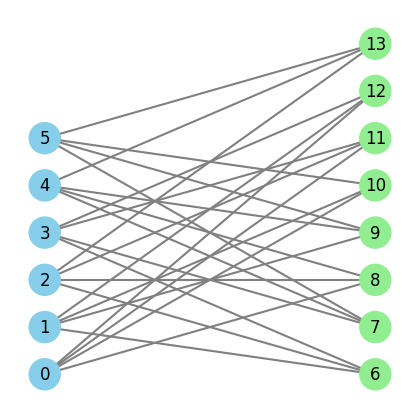

In [41]:
A = uniform_bipartite_graph()
G = nx.from_numpy_array(A)

plt.figure(figsize=(4, 4))  
# Identify node sets
left_nodes = list(range(6))
right_nodes = list(range(6, 14))

# Set positions for visualization
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(left_nodes))
pos.update((node, (2, index)) for index, node in enumerate(right_nodes))

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=['skyblue'] * 6 + ['lightgreen'] * 8, node_size=500, edge_color='gray', width=1.5)
plt.show()

In [43]:
A1 = uniform_bipartite_graph()
A2 = uniform_bipartite_graph()
A1 /= np.sum(A1)
A2 /= np.sum(A2)
c = get_degree_cost(A1, A2)

w_indep = independent_weight_couplings(A1,A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.0001, 10000, 1e-10)
print('Entropic ORTC cost: ', entropic_cost)

Independent coupling cost:  0.00021701388888888882
ORTC cost:  0.0
Entropic ORTC cost:  7.37099957337634e-08


Are there examples where the ORTC cost falls between zero and the independent coupling cost? Yes.

In [44]:
A1 = np.zeros((13, 13))
A1[0, 1] = 1
A1[0, 2] = 1
A1[0, 3] = 1
A1[1, 4] = 1
A1[2, 4] = 1
A1[3, 4] = 1
A1[4, 5] = 1
A1[4, 6] = 1
A1[4, 7] = 1
A1[5, 8] = 1
A1[6, 8] = 1
A1[7, 8] = 1
A1[8, 9] = 1
A1[8, 10] = 1
A1[8, 11] = 1
A1[9, 12] = 1
A1[10, 12] = 1
A1[11, 12] = 1
A1 = A1 + A1.T

arr_extracted = np.r_[0:5, 7:13] 
A2 = A1[np.ix_(arr_extracted, arr_extracted)]


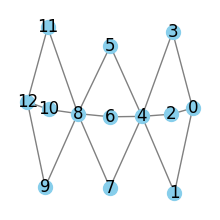

In [9]:
G = nx.from_numpy_array(A1)
plt.figure(figsize=(2, 2)) 
nx.draw(G, with_labels=True, node_color='skyblue', node_size=100, font_size=12, edge_color='gray')
plt.show()

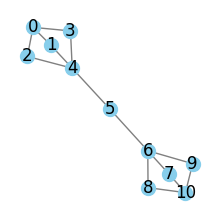

In [10]:
G = nx.from_numpy_array(A2)
plt.figure(figsize=(2, 2)) 
nx.draw(G, with_labels=True, node_color='skyblue', node_size=100, font_size=12, edge_color='gray')
plt.show()

In [45]:
A1 /= np.sum(A1)
A2 /= np.sum(A2)
c = get_degree_cost(A1, A2)

w_indep = independent_weight_couplings(A1,A2)
d = np.sum(w_indep, axis=(2, 3))
cost_indep = np.sum(d * c)
print('Independent coupling cost: ', cost_indep)

_, ortc_cost, weight = glop_v2(A1, A2, c, vertex=True)
print('ORTC cost: ', ortc_cost)

_, entropic_cost, _, _, _ = entropic_ortc(A1, A2, c, 0.001, 10000, 1e-10)
print('Entropic ORTC cost: ', entropic_cost)

Independent coupling cost:  0.0034564751826656587
ORTC cost:  0.0011180398085160002
Entropic ORTC cost:  0.0011562360691510674


### Issue of NetOTC Cost Exceeding ORTC Cost

Theoretically, the NetOTC cost should always be less than or equal to the ORTC cost. However, we have observed cases where the ORTC cost is unexpectedly lower than the NetOTC cost.

Upon investigating these cases, we identified that the discrepancy arises from the fact that the stationary distribution of the obtained transition coupling may not be unique. The current Python implementation of the OTC code returns an arbitrary stationary distribution, using this to compute the cost. To address this issue, we modified the function to return the stationary distribution that minimizes the corresponding cost among all possible stationary distributions. As a result, the NetOTC cost was consistently observed to be equal to or less than the ORTC cost.

The trade-off of this adjustment is that finding the cost-minimizing stationary distribution requires solving a linear programming problem, which may increase computation time compared to the previous method. However, this adjustment is necessary to ensure accurate results.

In [17]:
A1 = random_tree(7, 7)
n = A1.shape[0]
perm = np.random.permutation(n)
A2 = A1[np.ix_(perm, perm)]

# Get cost function
c = get_degree_cost(A1, A2)
A1 /= np.sum(A1)
A2 /= np.sum(A2)

# Get transition matrices
P1 = adj_to_trans(A1)
P2 = adj_to_trans(A2)

# Run algorithm
_, ortc_cost, ortc_weight = glop_v2(A1, A2, c, vertex=True)
ortc_alignment = np.sum(ortc_weight, axis=(2, 3))
_, otc_cost, _, otc_alignment = exact_otc(P1, P2, c)
print('ORTC cost: ', ortc_cost)
print('NetOTC cost: ', otc_cost)

ORTC cost:  0.0
NetOTC cost:  0.0


### Example: Independent Edge Removal from Two Complete Graphs
Consider two complete graphs with the same number of nodes. We remove one edge at a time independently from each graph, calculating the independent coupling cost and ORTC cost at each step. The results are then plotted, including the entropic ORTC cost and the KL divergence between the stationary distributions of the independent weight coupling and ORTC weight.

In [67]:
def remove_edges_from_complete_graph(n):
    A1 = stochastic_block_model([n], np.array([[1.0]]))

    # Random permutation
    perm = np.random.permutation(n)
    A2 = A1[np.ix_(perm, perm)]

    ortc_cost_list = []
    entropic_ortc_cost_list = []
    independent_cost_list = []
    kl_divergence = []

    # Find all the edges in the upper triangular part of the matrix (since it's symmetric)
    edges1 = [(i, j) for i in range(n) for j in range(i+1, n) if A1[i, j] > 0]
    edges2 = [(i, j) for i in range(n) for j in range(i+1, n) if A2[i, j] > 0]

    # Run algorithm
    for i in range(20):
        A1 /= np.sum(A1)
        A2 /= np.sum(A2)
        c = get_degree_cost(A1, A2)

        w_indep = independent_weight_couplings(A1, A2)    
        d = np.sum(w_indep, axis=(2, 3))
        cost_indep = np.sum(d * c)
        independent_cost_list.append(cost_indep)
        
        _, cost, weight = glop_v2(A1, A2, c, vertex=True)
        d_ortc = np.sum(weight, axis=(2, 3))
        ortc_cost_list.append(cost)
        
        _, entropic_cost, _, _, _ = entropic_ortc_log(A1, A2, c, 0.00001, 10000, 1e-10)
        entropic_ortc_cost_list.append(entropic_cost)
        
        kl_divergence.append(entropy(d.flatten(), d_ortc.flatten()))
        
        edge_to_remove1 = random.choice(edges1)
        i, j = edge_to_remove1
        A1[i, j] = 0
        A1[j, i] = 0
        
        edge_to_remove2 = random.choice(edges2)
        i, j = edge_to_remove2
        A2[i, j] = 0
        A2[j, i] = 0
        
    return independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence

In [56]:
def plot(independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence):
    # Create figure and axis objects
    fig, ax1 = plt.subplots()

    # Plotting independent, ortc, and entropic ortc costs on the primary y-axis
    ax1.plot(independent_cost_list, marker='o', linestyle='-', color='b', label='independent')
    ax1.plot(ortc_cost_list, marker='o', linestyle='-', color='r', label='ortc')
    ax1.plot(entropic_ortc_cost_list, marker='o', linestyle='-', color='g', label='entropic ortc')

    # Label for primary y-axis
    ax1.set_xlabel('Number of edges removed')
    ax1.set_ylabel('Cost', color='black')

    # Set xticks
    ax1.set_xticks(np.arange(0, 21, 2))

    # Add grid and legend for the first axis
    ax1.grid(True)
    ax1.legend(loc='upper left')

    # Create a secondary y-axis for the KL divergence
    ax2 = ax1.twinx()

    # Plotting kl_divergence on the secondary y-axis
    ax2.plot(kl_divergence, marker='o', linestyle='-', color='y', label='kl divergence')

    # Label for secondary y-axis
    ax2.set_ylabel('KL Divergence', color='y')

    # Add legend for the second axis
    ax2.legend(loc='upper right')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [54]:
independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence = remove_edges_from_complete_graph(7)
print(ortc_cost_list)
print(entropic_ortc_cost_list)
print(independent_cost_list)
print(kl_divergence)

/Users/bongsooyi/ORTC/ortc/entropicORTC_log.py:51: RuntimeWarning: invalid value encountered in divide
  np.log(d[:, :, np.newaxis] * A1[:, np.newaxis, :] / d1[:, np.newaxis, np.newaxis] + 1e-323)) - eps * t


[0.0, 1.0082011187093414e-17, 4.606864958928597e-17, 0.0008175592489996419, 0.0012670832569002712, 4.2081639498221514e-17, 0.001945495605468755, 0.0013440212673611197, 0.0030174927113703256, 0.003957922419460906, 0.0034064220926462987, 0.004279450804953272, 0.0045763888888889145, 0.0055426371149511185, 0.005049999999999994, 0.005049999999999994, 0.005049999999999994, 0.005049999999999994, 0.0038866026520347646, 0.006518454218107001]
[0.0, 1.0754800046025216e-06, 8.27118066795052e-07, 0.00037244946952636767, 0.0007865482011930311, 6.473165823791662e-05, 0.0009540452644702842, 0.0007477538026928209, 0.0021950460350991384, 0.0023563298204252086, 0.002572578049946549, 0.002841139670760366, 0.0025575208346521943, nan, nan, nan, nan, nan, nan, nan]
[0.0, 0.00023437499999999988, 0.0006368889127615655, 0.0008175592489996926, 0.0012670832569005224, 0.0014188048514744798, 0.00194549560546875, 0.002047146267361111, 0.0030174927113702605, 0.00395792241946088, 0.003406422092646581, 0.00427945080495

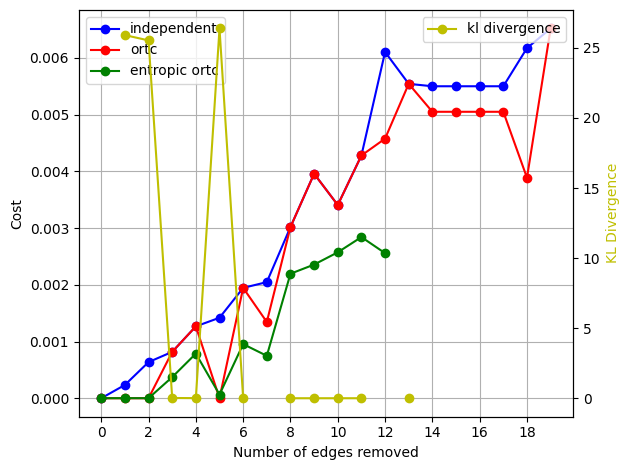

In [57]:
plot(independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence)

/Users/bongsooyi/ORTC/ortc/entropicORTC_log.py:51: RuntimeWarning: invalid value encountered in divide
  np.log(d[:, :, np.newaxis] * A1[:, np.newaxis, :] / d1[:, np.newaxis, np.newaxis] + 1e-323)) - eps * t


[0.0, 2.116838583826996e-17, 0.0004930134053606087, 0.0008753630596788831, 0.001289463412346022, 0.0011922912784006511, 0.0013419053819444533, 0.0008483965014577232, 0.0008483965014577232, 0.000754362008799957, 0.0017310495626822165, 0.0017310495626822165, 0.0018696581196581282, 0.0012056327160493846, 0.0019536141372401717, 0.0029588655146506365, 0.0040999999999999995, 0.005144032921810704, 0.005144032921810706, 0.005961853780864208]
[0.0, 1.0754800046025216e-06, 0.0004930081833095165, 0.0005890809526523665, 0.0012642588567087728, 0.0009071378351796963, 0.0013410414186177861, 0.0005801500632259636, 0.0005801500632259636, 0.0005939085742286276, 0.0013388260229782606, 0.0013388260229782606, 0.001601316325536511, 0.001205760510580219, 0.0019536132964958143, 0.0029588647494467007, 0.004099434296784481, nan, nan, nan]
[0.0, 0.00023437499999999988, 0.0004930134053606093, 0.0008753630596788822, 0.0012894634123460146, 0.0011922912784004174, 0.001341905381944444, 0.0008483965014577256, 0.000848

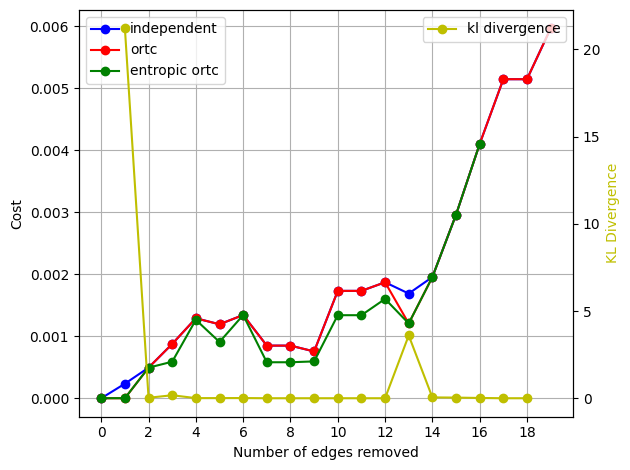

In [58]:
independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence = remove_edges_from_complete_graph(7)
print(ortc_cost_list)
print(entropic_ortc_cost_list)
print(independent_cost_list)
print(kl_divergence)
plot(independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence)

/Users/bongsooyi/ORTC/ortc/entropicORTC_log.py:51: RuntimeWarning: invalid value encountered in divide
  np.log(d[:, :, np.newaxis] * A1[:, np.newaxis, :] / d1[:, np.newaxis, np.newaxis] + 1e-323)) - eps * t


[0.0, 2.4011560871748973e-18, 0.0004930134053606095, 0.0006234111920476948, 0.001169081734107628, 0.0012907326743143161, 0.002009765625000005, 0.002372363565962093, 0.003124488827093762, 0.0032075617283950585, 0.0029877358263258047, 0.0031419629321727325, 0.004134615384615394, 0.006489395378284311, 0.006489395378284311, 0.005004160502958582, 0.004882812500000004, 0.0052518665477084905, 0.0052518665477084905, 0.008922740524781335]
[0.0, 1.075480004602534e-06, 0.0004930081833095135, 0.0006223491865318461, 0.0006358309609155469, 0.00089110023404038, 0.00142043466463416, 0.0020470594659887575, 0.002093368001759735, 0.0026120183631901037, 0.0026357580017678825, 0.002652645048054553, 0.003083334774653758, 0.005583521301912649, 0.005583521301912649, 0.0045269298388366545, 0.004292170077730365, 0.0052230762419944515, 0.005223076241994474, nan]
[0.0, 0.00023437499999999988, 0.0004930134053606094, 0.0006234111920476957, 0.0011690817341076297, 0.0012907326743143194, 0.002009765625, 0.002372363565

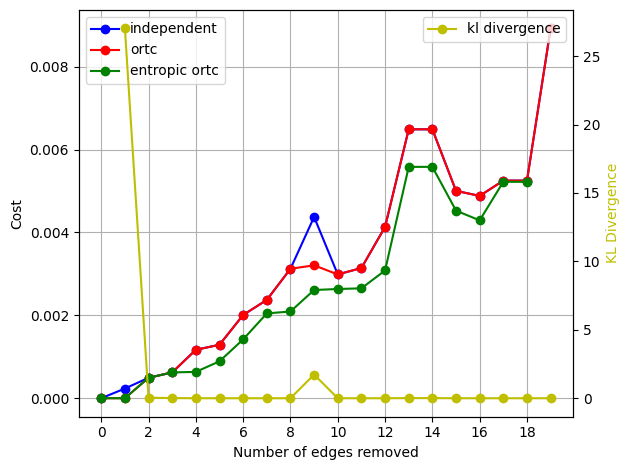

In [59]:
independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence = remove_edges_from_complete_graph(7)
print(ortc_cost_list)
print(entropic_ortc_cost_list)
print(independent_cost_list)
print(kl_divergence)
plot(independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence)

[0.0, 9.257264739008387e-18, 0.0004930134053606091, 0.0008049458923944511, 0.0013230205577039072, 0.0019531249999999974, 0.0023259259259259457, 0.0016659725114535598, 0.002617205279927176, 0.003483285288019009, 0.005067135716670852, 0.007156461307287761, 0.007849999999999989, 0.008459076360310937, 0.008459076360310937, 0.013305664062500017, 0.013305664062500017, 0.012689618258017505, 0.015299479166666682, 0.010345804988662133]
[0.0, 4.015948089442086e-31, 0.00023582470278128955, 0.00036985122139156484, 0.00020141076994368044, 0.0009340491720903286, 0.0011702518121546445, 0.0014059610961295963, 0.0022340720221957744, 0.003027983927855913, 0.004896155129281306, 0.00054752066115702, 0.007112014945106377, 0.008339025280932793, 0.008339025280932793, nan, nan, nan, nan, nan]
[0.0, 0.0002343749999999999, 0.0004930134053606094, 0.0008049458923944529, 0.0013230205577040507, 0.001953125, 0.002325925925925925, 0.0016659725114535604, 0.002617205279927174, 0.003483285288019015, 0.005067135716670843

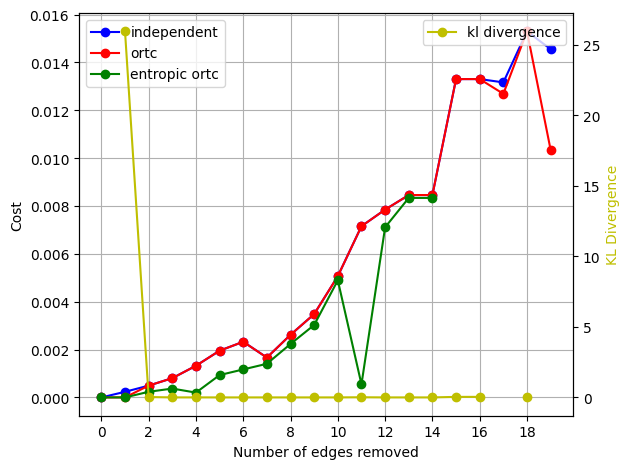

In [68]:
independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence = remove_edges_from_complete_graph(7)
print(ortc_cost_list)
print(entropic_ortc_cost_list)
print(independent_cost_list)
print(kl_divergence)
plot(independent_cost_list, ortc_cost_list, entropic_ortc_cost_list, kl_divergence)

### Isomorphism Experiment

We generate 300 random networks in each class. For each random network, we permute its vertices and apply the algorithms to the two isomorphic networks. We report the percentage of times the output alignment of an algorithm yields an isomorphism of the given graphs.

- SBM: 
    - SBM (7,7,7)
    - SBM (7,7,7,7)
    - SBM (10,8,6)
    
    The given tuple informs the number of vertices in each block. For example, SBM (7,7,7,7) indicates an SBM having 4 blocks with 7 vertices in each block. SBM (10,8,6) has 3 blocks, and each block has 10, 8, and 6 vertices. The connection probabilities within the block were fixed to 0.7, and the probabilities between blocks were 0.1.
- Erdos-Renyi network: 
    - $n \in \{6, . . . , 15\}, p = 1/3 $
    - $n \in \{6, . . . , 15\}, p = 2/3 $
    - $n \in \{16, . . . , 25\}, p = 1/4 $
    - $n \in \{16, . . . , 25\}, p = 3/4 $
- Random lollipop network (with adding edges inside the candy): \
    The number of vertices in the candy part is randomly chosen between 7 and 15. The number of vertices in the stick part is also determined between 7 and 15.
    We also add edges inside the candy to vary the lollipop. With a probability of 0.5, we connect an edge between pair of vertices in the candy.
- Random weighted lollipop network (without adding edges inside the candy): \
     The number of vertices in the candy part is randomly chosen between 10 and 20. The number of vertices in the stick part is also determined between 10 and 20.
- Random Tree network: \
    We use Prufer code to generate random tree networks. The number of vertices is randomly chosen between 10 and 20.
- Weighted Star network 